<a href="https://colab.research.google.com/github/hoky1227/Transformer_based-recommendation/blob/main/Transformer_%EC%83%81%ED%92%88%EC%B6%94%EC%B2%9C_based_on_0328_JW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/'

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install sentencepiece
!pip install tensorflow-addons
!pip install -q pyyaml h5py

     |████████████████████████████████| 2.0MB 20.0MB/s 
     |████████████████████████████████| 3.2MB 49.4MB/s 
     |████████████████████████████████| 890kB 50.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=a3815e2f752b62daaffd5b6a917046ffddad1ebeb8276a26d80cdb2593c8a5dd
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 19.7MB/s 
     |████████████████████████████████| 706kB 15.3MB/s 


In [3]:
import numpy as np
import pandas as pd
from dateutil.parser import parse
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import re
import torch

#### 내 데이터 불러오기

In [4]:
data = pd.read_csv(path + 'data_cutted_5.csv')
data.pop('Unnamed: 0')
data = data.sample(frac=1).reset_index(drop=True)
data

,Detail,label
0,S/4 CACTI CANDLES&&HOLIDAY FUN LUDO&&CAT BOWL&...,PINK FLORAL FELTCRAFT SHOULDER BAG
1,SILK PURSE RUSSIAN DOLL BLUE&&LOVE BUILDING BL...,BLUE GREEN EMBROIDERY COSMETIC BAG
2,RIBBON REEL STRIPES DESIGN&&RIBBON REEL SPOTS ...,GLASS ETCHED T-LIGHT HOLDER MEDIUM
3,ETCHED GLASS COASTER&&PACK OF 20 SKULL PAPER N...,HANGING HEART ZINC T-LIGHT HOLDER
4,PLASTERS IN TIN WOODLAND ANIMALS&&PLASTERS IN ...,LUNCH BAG SPACEBOY DESIGN
...,...,...
71200,ENAMEL MEASURING JUG CREAM&&CREAM HEART CARD H...,IVORY KITCHEN SCALES
71201,TOILET METAL SIGN&&SAVE THE PLANET MUG&&KINGS ...,POTTERING IN THE SHED METAL SIGN
71202,IVORY HANGING DECORATION HEART&&HEART IVORY T...,COLOUR GLASS T-LIGHT HOLDER HANGING
71203,LAVENDER SCENTED FABRIC HEART&&PLACE SETTING W...,MURANO STYLE GLASS BRACELET PINK


In [5]:
train_df = data.copy()
train_df.rename(columns = {'Detail':'train'}, inplace=True)
train_df

,train,label
0,S/4 CACTI CANDLES&&HOLIDAY FUN LUDO&&CAT BOWL&...,PINK FLORAL FELTCRAFT SHOULDER BAG
1,SILK PURSE RUSSIAN DOLL BLUE&&LOVE BUILDING BL...,BLUE GREEN EMBROIDERY COSMETIC BAG
2,RIBBON REEL STRIPES DESIGN&&RIBBON REEL SPOTS ...,GLASS ETCHED T-LIGHT HOLDER MEDIUM
3,ETCHED GLASS COASTER&&PACK OF 20 SKULL PAPER N...,HANGING HEART ZINC T-LIGHT HOLDER
4,PLASTERS IN TIN WOODLAND ANIMALS&&PLASTERS IN ...,LUNCH BAG SPACEBOY DESIGN
...,...,...
71200,ENAMEL MEASURING JUG CREAM&&CREAM HEART CARD H...,IVORY KITCHEN SCALES
71201,TOILET METAL SIGN&&SAVE THE PLANET MUG&&KINGS ...,POTTERING IN THE SHED METAL SIGN
71202,IVORY HANGING DECORATION HEART&&HEART IVORY T...,COLOUR GLASS T-LIGHT HOLDER HANGING
71203,LAVENDER SCENTED FABRIC HEART&&PLACE SETTING W...,MURANO STYLE GLASS BRACELET PINK


#### 학습 데이터의 토큰 갯수 분포 확인

In [6]:
train_df['token_len'] = [len(sum([i.split(' ') for i in aaa.split('&&')], [])) for aaa in train_df['train']]

token_len_cate = []
for i in train_df['token_len']:
    if i >= 0 and i < 100:
        token_len_cate.append('0:100')
    elif i >= 100 and i < 200:
        token_len_cate.append('100:200')
    elif i >= 200 and i < 300:
        token_len_cate.append('200:300')
    elif i >= 300 and i < 400:
        token_len_cate.append('300:400')
    elif i >= 400 and i < 500:
        token_len_cate.append('400:500')
    elif i >= 500 and i < 600:
        token_len_cate.append('500:600')
    elif i >= 600 and i < 700:
        token_len_cate.append('600:700')
    elif i >= 700 and i < 800:
        token_len_cate.append('700:800')
    elif i >= 800 and i < 900:
        token_len_cate.append('800:900')
    elif i >= 900:
        token_len_cate.append('900:')
train_df['token_len_cate'] = token_len_cate

[71205]


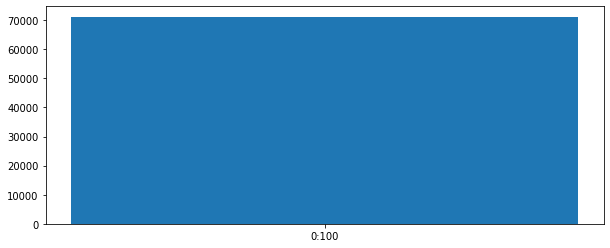

In [7]:
token_len_sort = sorted({i:j for i, j in zip(train_df['token_len_cate'].value_counts().keys(), train_df['token_len_cate'].value_counts().values)}.items(), key=lambda x:x[0])
x = [i for (i,_) in token_len_sort]
y = [i for (_,i) in token_len_sort]
print(y)

plt.figure(figsize=(10, 4))
plt.bar(x, y)
plt.show()

#### 토큰 갯수 512 이하로 처리

In [8]:
filtering_train_df = train_df.copy()

In [9]:
filtering_train_df = train_df[train_df['token_len']<400].reset_index(drop=True)
filtering_train_df['token_len'].max()

29

In [10]:
cut = round(len(filtering_train_df) * 0.8)
# data.rename(columns = {'Detail':'train'}, inplace=True)
filtering_train_df, filtering_test_df = filtering_train_df[:cut], filtering_train_df[cut:]

In [52]:
filtering_test_df = filtering_test_df.reset_index(drop=True)

In [11]:
print(len(filtering_train_df))
len(filtering_test_df)

56964


14241

#### 학습을 위해 토큰으로 자르기

In [12]:
filtering_train_df['split_train_token'] = ['<esp> ' + i.strip().replace('&&', ' <esp> ') + ' <esp>' for i in filtering_train_df['train']]
filtering_train_df['split_label_token'] = ['<esp> ' + i.strip() + ' <esp>' for i in filtering_train_df['label']]
# filtering_train_df['split_train_token'] = ['<sos> ' + i.strip().replace('&&', ' <eos> ') + ' <eos>' for i in filtering_train_df['train']]
# filtering_train_df['split_label_token'] = ['<sos> ' + i.strip() + ' <eos>' for i in filtering_train_df['label']]

In [13]:
filtering_train_df.head()

,train,label,token_len,token_len_cate,split_train_token,split_label_token
0,S/4 CACTI CANDLES&&HOLIDAY FUN LUDO&&CAT BOWL&...,PINK FLORAL FELTCRAFT SHOULDER BAG,11,0:100,<esp> S/4 CACTI CANDLES <esp> HOLIDAY FUN LUDO...,<esp> PINK FLORAL FELTCRAFT SHOULDER BAG <esp>
1,SILK PURSE RUSSIAN DOLL BLUE&&LOVE BUILDING BL...,BLUE GREEN EMBROIDERY COSMETIC BAG,19,0:100,<esp> SILK PURSE RUSSIAN DOLL BLUE <esp> LOVE ...,<esp> BLUE GREEN EMBROIDERY COSMETIC BAG <esp>
2,RIBBON REEL STRIPES DESIGN&&RIBBON REEL SPOTS ...,GLASS ETCHED T-LIGHT HOLDER MEDIUM,17,0:100,<esp> RIBBON REEL STRIPES DESIGN <esp> RIBBON ...,<esp> GLASS ETCHED T-LIGHT HOLDER MEDIUM <esp>
3,ETCHED GLASS COASTER&&PACK OF 20 SKULL PAPER N...,HANGING HEART ZINC T-LIGHT HOLDER,18,0:100,<esp> ETCHED GLASS COASTER <esp> PACK OF 20 SK...,<esp> HANGING HEART ZINC T-LIGHT HOLDER <esp>
4,PLASTERS IN TIN WOODLAND ANIMALS&&PLASTERS IN ...,LUNCH BAG SPACEBOY DESIGN,18,0:100,<esp> PLASTERS IN TIN WOODLAND ANIMALS <esp> P...,<esp> LUNCH BAG SPACEBOY DESIGN <esp>


In [14]:
MAX_LENGTH = 128

In [15]:
# # for i in range(len(train_token)):
# #     if len(train_token[i]) > MAX_LENGTH:
# #         while 1:
# #             id = train_token[i].index('<esp>')
# #             train_token[i] = train_token[i][id:]
# #             if len(train_token[i]) <= MAX_LENGTH:
# #                 break
# for i in range(len(filtering_train_df)):
#     filtering_train_df['split_train_token'][i] = filtering_train_df['split_train_token'][i].split(' ')
#     if len(filtering_train_df['split_train_token'][i]) > MAX_LENGTH:
#         while 1:
#             id = filtering_train_df['split_train_token'][i].index('<esp>')
#             filtering_train_df['split_train_token'][i] = filtering_train_df['split_train_token'][i][id:]
#             # tokenized_texts[i][0] = '[CLS]'
#             if len(filtering_train_df['split_train_token'][i]) <= MAX_LENGTH:
#                 break
#     filtering_train_df['split_train_token'][i] = ' '.join(x for x in filtering_train_df['split_train_token'][i])

# filtering_train_df.head()

In [16]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(filtering_train_df['split_train_token'] + filtering_train_df['split_label_token'], target_vocab_size=2**13)

In [17]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2

In [18]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [2719]
종료 토큰 번호 : [2720]
단어 집합의 크기 : 2721


In [19]:
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [20]:
train_token, label_token = tokenize_and_filter(filtering_train_df['split_train_token'], filtering_train_df['split_label_token'])

In [21]:
print('질문 데이터의 크기(shape) :', train_token.shape)
print('답변 데이터의 크기(shape) :', label_token.shape)

질문 데이터의 크기(shape) : (56964, 128)
답변 데이터의 크기(shape) : (56964, 128)


#### GPU 작동 확인

In [22]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [23]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [24]:
# USE_CUDA = torch.cuda.is_available()
# print(USE_CUDA)

# device = torch.device('cuda:0' if USE_CUDA else 'cpu')
# print('학습을 진행하는 기기:',device)

In [25]:
!nvidia-smi

Fri Apr  2 02:42:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    27W /  70W |    222MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### 학습

In [ ]:
# import math
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class TransformerModel(nn.Module):

#     def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
#         super(TransformerModel, self).__init__()
#         from torch.nn import TransformerEncoder, TransformerEncoderLayer
#         self.model_type = 'Transformer'
#         self.src_mask = None
#         self.pos_encoder = PositionalEncoding(ninp, dropout)
#         encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
#         self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
#         self.encoder = nn.Embedding(ntoken, ninp)
#         self.ninp = ninp
#         self.decoder = nn.Linear(ninp, ntoken)

#         self.init_weights()

#     def _generate_square_subsequent_mask(self, sz):
#         mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
#         mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
#         return mask

#     def init_weights(self):
#         initrange = 0.1
#         self.encoder.weight.data.uniform_(-initrange, initrange)
#         self.decoder.bias.data.zero_()
#         self.decoder.weight.data.uniform_(-initrange, initrange)

#     def forward(self, src):
#         if self.src_mask is None or self.src_mask.size(0) != len(src):
#             device = src.device
#             mask = self._generate_square_subsequent_mask(len(src)).to(device)
#             self.src_mask = mask

#         src = self.encoder(src) * math.sqrt(self.ninp)
#         src = self.pos_encoder(src)
#         output = self.transformer_encoder(src, self.src_mask)
#         output = self.decoder(output)
#         return output

# class PositionalEncoding(nn.Module):

#     def __init__(self, d_model, dropout=0.1, max_len=5000):
#         super(PositionalEncoding, self).__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0).transpose(0, 1)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         x = x + self.pe[:x.size(0), :]
#         return self.dropout(x)

In [ ]:
# import torchtext
# from torchtext.data.utils import get_tokenizer
# # TEXT = torchtext.data.Field(tokenize=get_tokenizer("basic_english"),
# #                             init_token='<sos>',
# #                             eos_token='<eos>',
# #                             lower=True)
# train_txt, val_txt, test_txt = torchtext.datasets.WikiText2.splits(TEXT)
# TEXT.build_vocab(train_txt)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# def batchify(data, bsz):
#     data = TEXT.numericalize([data.examples[0].text])
#     # 데이터셋을 bsz 파트들로 나눕니다.
#     nbatch = data.size(0) // bsz
#     # 깔끔하게 나누어 떨어지지 않는 추가적인 부분(나머지들) 은 잘라냅니다.
#     data = data.narrow(0, 0, nbatch * bsz)
#     # 데이터에 대하여 bsz 배치들로 동등하게 나눕니다.
#     data = data.view(bsz, -1).t().contiguous()
#     return data.to(device)

# batch_size = 20
# eval_batch_size = 10
# train_data = batchify(train_txt, batch_size)
# val_data = batchify(val_txt, eval_batch_size)
# test_data = batchify(test_txt, eval_batch_size)

In [ ]:
# criterion = nn.CrossEntropyLoss()
# lr = 5.0 # 학습률
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

# import time
# def train():
#     model.train() # 학습 모드를 시작합니다.
#     total_loss = 0.
#     start_time = time.time()
#     ntokens = len(TEXT.vocab.stoi)
#     for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
#         data, targets = get_batch(train_data, i)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = criterion(output.view(-1, ntokens), targets)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
#         optimizer.step()

#         total_loss += loss.item()
#         log_interval = 200
#         if batch % log_interval == 0 and batch > 0:
#             cur_loss = total_loss / log_interval
#             elapsed = time.time() - start_time
#             print('| epoch {:3d} | {:5d}/{:5d} batches | '
#                   'lr {:02.2f} | ms/batch {:5.2f} | '
#                   'loss {:5.2f} | ppl {:8.2f}'.format(
#                     epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
#                     elapsed * 1000 / log_interval,
#                     cur_loss, math.exp(cur_loss)))
#             total_loss = 0
#             start_time = time.time()

# def evaluate(eval_model, data_source):
#     eval_model.eval() # 평가 모드를 시작합니다.
#     total_loss = 0.
#     ntokens = len(TEXT.vocab.stoi)
#     with torch.no_grad():
#         for i in range(0, data_source.size(0) - 1, bptt):
#             data, targets = get_batch(data_source, i)
#             output = eval_model(data)
#             output_flat = output.view(-1, ntokens)
#             total_loss += len(data) * criterion(output_flat, targets).item()
#     return total_loss / (len(data_source) - 1)

In [26]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 256
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': train_token,
        'dec_inputs': label_token[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': label_token[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [27]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
  
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
  
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
  
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
  
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [28]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.2

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [29]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [30]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [31]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [32]:
EPOCHS = 20

In [33]:
model.fit(dataset, epochs=EPOCHS)
# if tf.test.is_gpu_available():
#   print("On GPU:")
#   with tf.device("GPU:0"): # Or GPU:1 for the 2nd GPU, GPU:2 for the 3rd etc.
#     model.fit(dataset, epochs=EPOCHS)
#     # assert x.device.endswith("GPU:0")

Epoch 1/20
223/223 [==============================] - 111s 458ms/step - loss: 0.6450 - accuracy: 0.0115
Epoch 2/20
223/223 [==============================] - 103s 462ms/step - loss: 0.2901 - accuracy: 0.0554
Epoch 3/20
223/223 [==============================] - 103s 463ms/step - loss: 0.1886 - accuracy: 0.0628
Epoch 4/20
223/223 [==============================] - 103s 463ms/step - loss: 0.1321 - accuracy: 0.0696
Epoch 5/20
223/223 [==============================] - 103s 461ms/step - loss: 0.0973 - accuracy: 0.0742
Epoch 6/20
223/223 [==============================] - 103s 463ms/step - loss: 0.0775 - accuracy: 0.0768
Epoch 7/20
223/223 [==============================] - 103s 462ms/step - loss: 0.0674 - accuracy: 0.0780
Epoch 8/20
223/223 [==============================] - 103s 462ms/step - loss: 0.0623 - accuracy: 0.0786
Epoch 9/20
223/223 [==============================] - 103s 462ms/step - loss: 0.0587 - accuracy: 0.0791
Epoch 10/20
223/223 [==============================] - 103s 462m

In [34]:
# best_val_loss = float("inf")
# epochs = 1 # 에포크 수
# best_model = None

# for epoch in range(1, epochs + 1):
#     epoch_start_time = time.time()
#     train()
#     val_loss = evaluate(model, val_data)
#     print('-' * 89)
#     print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
#           'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
#                                      val_loss, math.exp(val_loss)))
#     print('-' * 89)

#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         best_model = model

#     scheduler.step()

In [35]:
name = 'Transformer_' + str(EPOCHS) + '.h5'
# name = 'Transformer_' + str(epochs) + '.pt'

In [36]:
model.save_weights(path+f'Transformer_{EPOCHS}_weights.ckpt')
# model.save(path + name)
# torch.save(model, path+name)
# tf.saved_model.save(model, path+name)

In [37]:
# model = tf.keras.models.load_model(path + name)
model.load_weights(path+f'Transformer_{EPOCHS}_weights.ckpt')

In [38]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

#   print('Input: {}'.format(sentence))
#   print('Output: {}'.format(predicted_sentence))

  return predicted_sentence


def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [39]:
filtering_train_df.head()

,train,label,token_len,token_len_cate,split_train_token,split_label_token
0,S/4 CACTI CANDLES&&HOLIDAY FUN LUDO&&CAT BOWL&...,PINK FLORAL FELTCRAFT SHOULDER BAG,11,0:100,<esp> S/4 CACTI CANDLES <esp> HOLIDAY FUN LUDO...,<esp> PINK FLORAL FELTCRAFT SHOULDER BAG <esp>
1,SILK PURSE RUSSIAN DOLL BLUE&&LOVE BUILDING BL...,BLUE GREEN EMBROIDERY COSMETIC BAG,19,0:100,<esp> SILK PURSE RUSSIAN DOLL BLUE <esp> LOVE ...,<esp> BLUE GREEN EMBROIDERY COSMETIC BAG <esp>
2,RIBBON REEL STRIPES DESIGN&&RIBBON REEL SPOTS ...,GLASS ETCHED T-LIGHT HOLDER MEDIUM,17,0:100,<esp> RIBBON REEL STRIPES DESIGN <esp> RIBBON ...,<esp> GLASS ETCHED T-LIGHT HOLDER MEDIUM <esp>
3,ETCHED GLASS COASTER&&PACK OF 20 SKULL PAPER N...,HANGING HEART ZINC T-LIGHT HOLDER,18,0:100,<esp> ETCHED GLASS COASTER <esp> PACK OF 20 SK...,<esp> HANGING HEART ZINC T-LIGHT HOLDER <esp>
4,PLASTERS IN TIN WOODLAND ANIMALS&&PLASTERS IN ...,LUNCH BAG SPACEBOY DESIGN,18,0:100,<esp> PLASTERS IN TIN WOODLAND ANIMALS <esp> P...,<esp> LUNCH BAG SPACEBOY DESIGN <esp>


In [40]:
predict(filtering_train_df['split_label_token'][2])

'<esp> RED SPOTTY COIR DOORMAT <esp>'

In [41]:
predict_item = [predict(i) for i in tqdm_notebook(filtering_train_df['split_train_token'])]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


KeyboardInterrupt: ignored

In [ ]:
filtering_train_df['predict_item'] = predict_item

In [ ]:
pd.Series([i in list(filtering_train_df['split_label_token']) for i in filtering_train_df['predict_item']]).value_counts()

In [ ]:
filtering_train_df.head()

In [ ]:
filtering_train_df.pop('token_len')
filtering_train_df.pop('token_len_cate')
filtering_train_df.head()

In [ ]:
filtering_train_df.to_csv(path + 'Transformer_outputs.csv', mode='w')

In [42]:
filtering_test_df['split_train_token'] = ['<esp> ' + i.strip().replace('&&', ' <esp> ') + ' <esp>' for i in filtering_test_df['train']]
filtering_test_df['split_label_token'] = ['<esp> ' + i.strip() + ' <esp>' for i in filtering_test_df['label']]

In [43]:
predict_item_test = [predict(i) for i in tqdm_notebook(filtering_test_df['split_train_token'])]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [45]:
filtering_test_df['predict_item'] = predict_item_test
pd.Series([i in list(filtering_test_df['split_label_token']) for i in filtering_test_df['predict_item']]).value_counts()

True     14040
False      201
dtype: int64

In [46]:
filtering_test_df.pop('token_len')
filtering_test_df.pop('token_len_cate')
filtering_test_df.head()

,train,label,split_train_token,split_label_token,predict_item
56964,ENAMEL FLOWER JUG CREAM&&DOOR MAT FAIRY CAKE&&...,RED SPOTTY TABLECLOTH,<esp> ENAMEL FLOWER JUG CREAM <esp> DOOR MAT F...,<esp> RED SPOTTY TABLECLOTH <esp>,<esp> ENAMEL BREAD BIN CREAM <esp>
56965,GAOLERS KEYS DECORATIVE GARDEN&&HAND OPEN SHAP...,SET OF 2 FANCY FONT TEA TOWELS,<esp> GAOLERS KEYS DECORATIVE GARDEN <esp> HAN...,<esp> SET OF 2 FANCY FONT TEA TOWELS <esp>,<esp> PAPER BUNTING RETRO SPOTS <esp>
56966,SET OF 9 HEART SHAPED BALLOONS&&SET OF 9 BLACK...,CERAMIC CHERRY CAKE MONEY BANK,<esp> SET OF 9 HEART SHAPED BALLOONS <esp> SET...,<esp> CERAMIC CHERRY CAKE MONEY BANK <esp>,<esp> ASSTD DESIGN BUBBLE GUM RING <esp>
56967,HANGING HEART ZINC T-LIGHT HOLDER&&OPULENT VEL...,COLOUR GLASS. STAR T-LIGHT HOLDER,<esp> HANGING HEART ZINC T-LIGHT HOLDER <esp> ...,<esp> COLOUR GLASS. STAR T-LIGHT HOLDER <esp>,<esp> HANGING HEART ZINC T-LIGHT HOLDER <esp>
56968,BAKING SET 9 PIECE RETROSPOT&&PARTY INVITES WO...,PARTY INVITES FOOTBALL,<esp> BAKING SET 9 PIECE RETROSPOT <esp> PARTY...,<esp> PARTY INVITES FOOTBALL <esp>,<esp> PARTY INVITES WOODLAND <esp>


In [53]:
filtering_test_df

,train,label,split_train_token,split_label_token,predict_item
0,ENAMEL FLOWER JUG CREAM&&DOOR MAT FAIRY CAKE&&...,RED SPOTTY TABLECLOTH,<esp> ENAMEL FLOWER JUG CREAM <esp> DOOR MAT F...,<esp> RED SPOTTY TABLECLOTH <esp>,<esp> ENAMEL BREAD BIN CREAM <esp>
1,GAOLERS KEYS DECORATIVE GARDEN&&HAND OPEN SHAP...,SET OF 2 FANCY FONT TEA TOWELS,<esp> GAOLERS KEYS DECORATIVE GARDEN <esp> HAN...,<esp> SET OF 2 FANCY FONT TEA TOWELS <esp>,<esp> PAPER BUNTING RETRO SPOTS <esp>
2,SET OF 9 HEART SHAPED BALLOONS&&SET OF 9 BLACK...,CERAMIC CHERRY CAKE MONEY BANK,<esp> SET OF 9 HEART SHAPED BALLOONS <esp> SET...,<esp> CERAMIC CHERRY CAKE MONEY BANK <esp>,<esp> ASSTD DESIGN BUBBLE GUM RING <esp>
3,HANGING HEART ZINC T-LIGHT HOLDER&&OPULENT VEL...,COLOUR GLASS. STAR T-LIGHT HOLDER,<esp> HANGING HEART ZINC T-LIGHT HOLDER <esp> ...,<esp> COLOUR GLASS. STAR T-LIGHT HOLDER <esp>,<esp> HANGING HEART ZINC T-LIGHT HOLDER <esp>
4,BAKING SET 9 PIECE RETROSPOT&&PARTY INVITES WO...,PARTY INVITES FOOTBALL,<esp> BAKING SET 9 PIECE RETROSPOT <esp> PARTY...,<esp> PARTY INVITES FOOTBALL <esp>,<esp> PARTY INVITES WOODLAND <esp>
...,...,...,...,...,...
14236,ENAMEL MEASURING JUG CREAM&&CREAM HEART CARD H...,IVORY KITCHEN SCALES,<esp> ENAMEL MEASURING JUG CREAM <esp> CREAM H...,<esp> IVORY KITCHEN SCALES <esp>,<esp> DOOR MAT UNION FLAG <esp>
14237,TOILET METAL SIGN&&SAVE THE PLANET MUG&&KINGS ...,POTTERING IN THE SHED METAL SIGN,<esp> TOILET METAL SIGN <esp> SAVE THE PLANET ...,<esp> POTTERING IN THE SHED METAL SIGN <esp>,<esp> BATHROOM METAL SIGN <esp>
14238,IVORY HANGING DECORATION HEART&&HEART IVORY T...,COLOUR GLASS T-LIGHT HOLDER HANGING,<esp> IVORY HANGING DECORATION HEART <esp> HE...,<esp> COLOUR GLASS T-LIGHT HOLDER HANGING <esp>,<esp> HEART T-LIGHT HOLDER <esp>
14239,LAVENDER SCENTED FABRIC HEART&&PLACE SETTING W...,MURANO STYLE GLASS BRACELET PINK,<esp> LAVENDER SCENTED FABRIC HEART <esp> PLAC...,<esp> MURANO STYLE GLASS BRACELET PINK <esp>,<esp> RED GINGHAM ROSE JEWELLERY BOX <esp>


In [54]:
filtering_test_df.to_csv(path + 'Transformer_test_outputs.csv', mode='w')

In [55]:
sum = 0
l = len(filtering_test_df)
for i in range(l):
    if filtering_test_df['split_label_token'][i] == filtering_test_df['predict_item'][i]:
        sum += 1

acc = sum / l
acc

0.02324274980689558

In [ ]:
predict('<esp> 집에 가고 싶어 <esp>')

'<esp> ASSORTED COLOUR BIRD ORNAMENT <esp>'

In [ ]:
predict('<esp> 지갑 <esp>')

'<esp> ASSORTED COLOUR BIRD ORNAMENT <esp>'

In [ ]:
predict('<esp> 이경전 <esp>')

'<esp> ASSORTED TUTTI FRUTTI SMALL PURSE <esp>'

In [ ]:
predict('<esp> 집에 가고 싶다 <esp>')

'<esp> ASSORTED SANSKRIT MINI NOTEBOOK <esp>'

In [ ]:
predict('''<esp> AGED GLASS SILVER T-LIGHT HOLDER <esp> ASSORTED COLOUR T-LIGHT HOLDER <esp> RIDGED GLASS T-LIGHT HOLDER <esp> BLACK SILVER FLOWER T-LIGHT HOLDER <esp> BLACK CANDELABRA T-LIGHT HOLDER <esp>''')

'<esp> RETRO SPOT LARGE MILK JUG <esp>'

In [ ]:
predict('<esp> AGED GLASS SILVER T-LIGHT HOLDER <esp>')

'<esp> WHITE HANGING HEART T-LIGHT HOLDER <esp>'

In [ ]:
predict('<esp> ASSORTED COLOUR T-LIGHT HOLDER <esp>')

'<esp> SET/5 RED SPOTTY LID GLASS BOWLS <esp>'

In [ ]:
predict('<esp> BLACK SILVER FLOWER T-LIGHT HOLDER <esp>')

'<esp> SILVER HANGING T-LIGHT HOLDER <esp>'

In [ ]:
predict('<esp> BLACK CANDELABRA T-LIGHT HOLDER <esp>')

'<esp> STEEL SWEETHEART ROUND TABLE CREAM <esp>'

In [ ]:
predict('<esp> AGED GLASS SILVER T-LIGHT HOLDER <esp> ASSORTED COLOUR T-LIGHT HOLDER <esp>')

'<esp> VICTORIAN GLASS HANGING T-LIGHT <esp>'

In [ ]:
predict('<esp> AGED GLASS SILVER T-LIGHT HOLDER <esp> BLACK SILVER FLOWER T-LIGHT HOLDER <esp>')

'<esp> WHITE HANGING HEART T-LIGHT HOLDER <esp>'

In [ ]:
predict('<esp> ASSORTED COLOUR T-LIGHT HOLDER <esp> RIDGED GLASS T-LIGHT HOLDER <esp> BLACK SILVER FLOWER T-LIGHT HOLDER <esp>')

'<esp> SMALL POPCORN HOLDER <esp>'

In [ ]:
predict('<esp> I wanna go home <esp>')

'<esp> ASSORTED COLOUR BIRD ORNAMENT <esp>'

In [ ]:
predict('<esp> Lee Kyoungjun <esp>')

'<esp> ASSORTED ELEPHANT TOY WITH BLUE T-SHIRT <esp>'

In [ ]:
predict('<esp> lee kyoungjun <esp> OWL DOORSTOP <esp>')

'<esp> VICTORIAN SEWING BOX SMALL <esp>'

In [ ]:
predict('<esp> lee kyoungjun <esp> OWL DOORSTOP <esp> DOOR MAT RED SPOT <esp> RED RETROSPOT CAKE STANDROSE CARAVAN DOORSTOP <esp>')

'<esp> SET OF 3 COLOURED  FLYING DUCKS <esp>'

In [ ]:
predict('<esp> OWL DOORSTOP <esp> DOOR MAT RED SPOT <esp> RED RETROSPOT CAKE STANDROSE CARAVAN DOORSTOP <esp> lee kyoungjun <esp>')

'<esp> SET OF 12 COFFEE BOTANICAL T-LIGHTS <esp>'

In [ ]:
predict('<esp> 이경전 <esp> 교수님 <esp> 집에 가고 싶어 <esp>')

'<esp> SMALL ROUND CUT GLASS CANDLESTICK <esp>'

In [ ]:
predict('<esp> 집에 <esp> 가고 <esp> 싶다 <esp>')

'<esp> COFFEE MUG PEARS  DESIGN <esp>'

In [ ]:
predict('<esp> I wanna <esp> go <esp> home <esp>')

'<esp> LOVE GARLAND PAINTED ZINC <esp>'

In [ ]:
predict('''<esp> EIGHT PIECE DINOSAUR SET <esp> WRAP,SUKI AND FRIENDS <esp> CAMOUFLAGE LED TORCH <esp> 60 GOLD AND SILVER FAIRY CAKE CASES <esp> PACK 6 HEART/ICE-CREAM PATCHES <esp> WHITE HANGING HEART T-LIGHT HOLDER <esp> LUNCH BAG SUKI  DESIGN <esp> SET OF 20 KIDS COOKIE CUTTERS <esp> METAL SIGN TAKE IT OR LEAVE IT <esp> GREEN GINGHAM FLOWER JEWELLERY BOX <esp> RED GINGHAM ROSE JEWELLERY BOX <esp> GIN + TONIC DIET METAL SIGN <esp> I'M ON HOLIDAY METAL SIGN <esp> CERAMIC BIRDHOUSE RED ROOF SMALL <esp> SET OF 2 TINS VINTAGE BATHROOM <esp> DOOR MAT HEARTS <esp>''')

'<esp> EIGHT PIECE CREEPY CRAWLIE SET <esp>'

In [ ]:
predict('''<esp> EIGHT PIECE DINOSAUR SET <esp> WRAP,SUKI AND FRIENDS <esp> CAMOUFLAGE LED TORCH <esp> 60 GOLD AND SILVER FAIRY CAKE CASES <esp> PACK 6 HEART/ICE-CREAM PATCHES <esp> WHITE HANGING HEART T-LIGHT HOLDER <esp> LUNCH BAG SUKI  DESIGN <esp> SET OF 20 KIDS COOKIE CUTTERS <esp> METAL SIGN TAKE IT OR LEAVE IT <esp> GREEN GINGHAM FLOWER JEWELLERY BOX <esp> RED GINGHAM ROSE JEWELLERY BOX <esp> GIN + TONIC DIET METAL SIGN <esp> ON HOLIDAY METAL SIGN <esp> CERAMIC BIRDHOUSE RED ROOF SMALL <esp> SET OF 2 TINS VINTAGE BATHROOM <esp> EIGHT PIECE CREEPY CRAWLIE SET <esp> EIGHT PIECE DINOSAUR SET <esp> WRAP,SUKI AND FRIENDS <esp>''')

'<esp> EIGHT PIECE DINOSAUR SET <esp>'

In [ ]:
predict('''<esp> EIGHT PIECE DINOSAUR SET <esp> WRAP,SUKI AND FRIENDS <esp> CAMOUFLAGE LED TORCH <esp> 60 GOLD AND SILVER FAIRY CAKE CASES <esp> PACK 6 HEART/ICE-CREAM PATCHES <esp> WHITE HANGING HEART T-LIGHT HOLDER <esp> LUNCH BAG SUKI  DESIGN <esp> SET OF 20 KIDS COOKIE CUTTERS <esp> METAL SIGN TAKE IT OR LEAVE IT <esp> GREEN GINGHAM FLOWER JEWELLERY BOX <esp> RED GINGHAM ROSE JEWELLERY BOX <esp> GIN + TONIC DIET METAL SIGN <esp> I'M ON HOLIDAY METAL SIGN <esp> CERAMIC BIRDHOUSE RED ROOF SMALL <esp> SET OF 2 TINS VINTAGE BATHROOM <esp> DOOR MAT HEARTS <esp> EIGHT PIECE CREEPY CRAWLIE SET <esp>''')

'<esp> EIGHT PIECE CREEPY CRAWLIE SET <esp>'

In [ ]:
predict('''<esp> PLEASE ONE PERSON METAL SIGN <esp> 3 STRIPEY MICE FELTCRAFT <esp> DOOR MAT HEARTS <esp> DOOR MAT UNION FLAG <esp>''')

'<esp> FELTCRAFT 6 FLOWER FRIENDS <esp>'

In [ ]:
predict('''<esp> PLEASE ONE PERSON METAL SIGN <esp> 3 STRIPEY MICE FELTCRAFT <esp> DOOR MAT HEARTS <esp> DOOR MAT UNION FLAG <esp> FELTCRAFT 6 FLOWER FRIENDS <esp> EIGHT PIECE DINOSAUR SET <esp>''')

'<esp> STRAWBERRY CHARLOTTE BAG <esp>'

In [ ]:
# def transformer(vocab_size, num_layers, dff,
#                 d_model, num_heads, dropout,
#                 name="transformer", stats='train'):

#   # 인코더의 입력
#   inputs = tf.keras.Input(shape=(None,), name="inputs")

#   # 디코더의 입력
#   dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

#   # 인코더의 패딩 마스크
#   enc_padding_mask = tf.keras.layers.Lambda(
#       create_padding_mask, output_shape=(1, 1, None),
#       name='enc_padding_mask')(inputs)

#   # 디코더의 룩어헤드 마스크(첫번째 서브층)
#   look_ahead_mask = tf.keras.layers.Lambda(
#       create_look_ahead_mask, output_shape=(1, None, None),
#       name='look_ahead_mask')(dec_inputs)

#   # 디코더의 패딩 마스크(두번째 서브층)
#   dec_padding_mask = tf.keras.layers.Lambda(
#       create_padding_mask, output_shape=(1, 1, None),
#       name='dec_padding_mask')(inputs)

#   # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
#   enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
#       d_model=d_model, num_heads=num_heads, dropout=dropout,
#   )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

#   # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
#   dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
#       d_model=d_model, num_heads=num_heads, dropout=dropout,
#   )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

#   # 다음 단어 예측을 위한 출력층
#   if stats == 'train':
#     outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)
# #   elif stats == 'test':


#   return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


# def create_padding_mask(x):
#   mask = tf.cast(tf.math.equal(x, 0), tf.float32)
#   # (batch_size, 1, 1, key의 문장 길이)
#   return mask[:, tf.newaxis, tf.newaxis, :]


# def create_look_ahead_mask(x):
#   seq_len = tf.shape(x)[1]
#   look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
#   padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
#   return tf.maximum(look_ahead_mask, padding_mask)


# def encoder(vocab_size, num_layers, dff,
#             d_model, num_heads, dropout,
#             name="encoder"):
#   inputs = tf.keras.Input(shape=(None,), name="inputs")

#   # 인코더는 패딩 마스크 사용
#   padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

#   # 포지셔널 인코딩 + 드롭아웃
#   embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
#   embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
#   embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
#   outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

#   # 인코더를 num_layers개 쌓기
#   for i in range(num_layers):
#     outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
#         dropout=dropout, name="encoder_layer_{}".format(i),
#     )([outputs, padding_mask])

#   return tf.keras.Model(
#       inputs=[inputs, padding_mask], outputs=outputs, name=name)
  

# def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
#   inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

#   # 인코더는 패딩 마스크 사용
#   padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

#   # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
#   attention = MultiHeadAttention(
#       d_model, num_heads, name="attention")({
#           'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
#           'mask': padding_mask # 패딩 마스크 사용
#       })

#   # 드롭아웃 + 잔차 연결과 층 정규화
#   attention = tf.keras.layers.Dropout(rate=dropout)(attention)
#   attention = tf.keras.layers.LayerNormalization(
#       epsilon=1e-6)(inputs + attention)

#   # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
#   outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
#   outputs = tf.keras.layers.Dense(units=d_model)(outputs)

#   # 드롭아웃 + 잔차 연결과 층 정규화
#   outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
#   outputs = tf.keras.layers.LayerNormalization(
#       epsilon=1e-6)(attention + outputs)

#   return tf.keras.Model(
#       inputs=[inputs, padding_mask], outputs=outputs, name=name)
  

# class PositionalEncoding(tf.keras.layers.Layer):
#   def __init__(self, position, d_model):
#     super(PositionalEncoding, self).__init__()
#     self.pos_encoding = self.positional_encoding(position, d_model)

#   def get_angles(self, position, i, d_model):
#     angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
#     return position * angles

#   def positional_encoding(self, position, d_model):
#     angle_rads = self.get_angles(
#         position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
#         i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
#         d_model=d_model)

#     # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
#     sines = tf.math.sin(angle_rads[:, 0::2])

#     # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
#     cosines = tf.math.cos(angle_rads[:, 1::2])

#     angle_rads = np.zeros(angle_rads.shape)
#     angle_rads[:, 0::2] = sines
#     angle_rads[:, 1::2] = cosines
#     pos_encoding = tf.constant(angle_rads)
#     pos_encoding = pos_encoding[tf.newaxis, ...]

#     print(pos_encoding.shape)
#     return tf.cast(pos_encoding, tf.float32)

#   def call(self, inputs):
#     return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]



# class MultiHeadAttention(tf.keras.layers.Layer):

#   def __init__(self, d_model, num_heads, name="multi_head_attention"):
#     super(MultiHeadAttention, self).__init__(name=name)
#     self.num_heads = num_heads
#     self.d_model = d_model

#     assert d_model % self.num_heads == 0

#     # d_model을 num_heads로 나눈 값.
#     # 논문 기준 : 64
#     self.depth = d_model // self.num_heads

#     # WQ, WK, WV에 해당하는 밀집층 정의
#     self.query_dense = tf.keras.layers.Dense(units=d_model)
#     self.key_dense = tf.keras.layers.Dense(units=d_model)
#     self.value_dense = tf.keras.layers.Dense(units=d_model)

#     # WO에 해당하는 밀집층 정의
#     self.dense = tf.keras.layers.Dense(units=d_model)

#   # num_heads 개수만큼 q, k, v를 split하는 함수
#   def split_heads(self, inputs, batch_size):
#     inputs = tf.reshape(
#         inputs, shape=(batch_size, -1, self.num_heads, self.depth))
#     return tf.transpose(inputs, perm=[0, 2, 1, 3])

#   def call(self, inputs):
#     query, key, value, mask = inputs['query'], inputs['key'], inputs[
#         'value'], inputs['mask']
#     batch_size = tf.shape(query)[0]

#     # 1. WQ, WK, WV에 해당하는 밀집층 지나기
#     # q : (batch_size, query의 문장 길이, d_model)
#     # k : (batch_size, key의 문장 길이, d_model)
#     # v : (batch_size, value의 문장 길이, d_model)
#     # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
#     query = self.query_dense(query)
#     key = self.key_dense(key)
#     value = self.value_dense(value)

#     # 2. 헤드 나누기
#     # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
#     # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
#     # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
#     query = self.split_heads(query, batch_size)
#     key = self.split_heads(key, batch_size)
#     value = self.split_heads(value, batch_size)

#     # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
#     # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
#     scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
#     # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
#     scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

#     # 4. 헤드 연결(concatenate)하기
#     # (batch_size, query의 문장 길이, d_model)
#     concat_attention = tf.reshape(scaled_attention,
#                                   (batch_size, -1, self.d_model))

#     # 5. WO에 해당하는 밀집층 지나기
#     # (batch_size, query의 문장 길이, d_model)
#     outputs = self.dense(concat_attention)

#     return outputs


# def scaled_dot_product_attention(query, key, value, mask):
#   # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
#   # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
#   # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
#   # padding_mask : (batch_size, 1, 1, key의 문장 길이)

#   # Q와 K의 곱. 어텐션 스코어 행렬.
#   matmul_qk = tf.matmul(query, key, transpose_b=True)

#   # 스케일링
#   # dk의 루트값으로 나눠준다.
#   depth = tf.cast(tf.shape(key)[-1], tf.float32)
#   logits = matmul_qk / tf.math.sqrt(depth)

#   # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
#   # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
#   if mask is not None:
#     logits += (mask * -1e9)

#   # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
#   # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
#   attention_weights = tf.nn.softmax(logits, axis=-1)

#   # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
#   output = tf.matmul(attention_weights, value)

#   return output, attention_weights


# def decoder(vocab_size, num_layers, dff,
#             d_model, num_heads, dropout,
#             name='decoder'):
#   inputs = tf.keras.Input(shape=(None,), name='inputs')
#   enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

#   # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
#   look_ahead_mask = tf.keras.Input(
#       shape=(1, None, None), name='look_ahead_mask')
#   padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

#   # 포지셔널 인코딩 + 드롭아웃
#   embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
#   embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
#   embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
#   outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

#   # 디코더를 num_layers개 쌓기
#   for i in range(num_layers):
#     outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
#         dropout=dropout, name='decoder_layer_{}'.format(i),
#     )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

#   return tf.keras.Model(
#       inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
#       outputs=outputs,
#       name=name)
  

# def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
#   inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
#   enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

#   # 룩어헤드 마스크(첫번째 서브층)
#   look_ahead_mask = tf.keras.Input(
#       shape=(1, None, None), name="look_ahead_mask")

#   # 패딩 마스크(두번째 서브층)
#   padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

#   # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
#   attention1 = MultiHeadAttention(
#       d_model, num_heads, name="attention_1")(inputs={
#           'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
#           'mask': look_ahead_mask # 룩어헤드 마스크
#       })

#   # 잔차 연결과 층 정규화
#   attention1 = tf.keras.layers.LayerNormalization(
#       epsilon=1e-6)(attention1 + inputs)

#   # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
#   attention2 = MultiHeadAttention(
#       d_model, num_heads, name="attention_2")(inputs={
#           'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
#           'mask': padding_mask # 패딩 마스크
#       })

#   # 드롭아웃 + 잔차 연결과 층 정규화
#   attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
#   attention2 = tf.keras.layers.LayerNormalization(
#       epsilon=1e-6)(attention2 + attention1)

#   # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
#   outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
#   outputs = tf.keras.layers.Dense(units=d_model)(outputs)

#   # 드롭아웃 + 잔차 연결과 층 정규화
#   outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
#   outputs = tf.keras.layers.LayerNormalization(
#       epsilon=1e-6)(outputs + attention2)

#   return tf.keras.Model(
#       inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
#       outputs=outputs,
#       name=name)
  

# class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

#   def __init__(self, d_model, warmup_steps=4000):
#     super(CustomSchedule, self).__init__()
#     self.d_model = d_model
#     self.d_model = tf.cast(self.d_model, tf.float32)
#     self.warmup_steps = warmup_steps

#   def __call__(self, step):
#     arg1 = tf.math.rsqrt(step)
#     arg2 = step * (self.warmup_steps**-1.5)

#     return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


# def loss_function(y_true, y_pred):
#   y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

#   loss = tf.keras.losses.SparseCategoricalCrossentropy(
#       from_logits=True, reduction='none')(y_true, y_pred)

#   mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
#   loss = tf.multiply(loss, mask)

#   return tf.reduce_mean(loss)